In [ ]:
import torch
import numpy as np
import random
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import scvi

import subprocess
subprocess.check_output(['hostname']).decode().replace('\n','') # to check machine name 

In [ ]:
def fix_seed(seed_value = 42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_value)

def scatter_hist(x, y, ax, ax_histx, ax_histy, label):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=0.5)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 100
    ax_histx.hist(x, bins=bins, label = label, density=True, alpha = 0.5)
    ax_histy.hist(y, bins=bins, orientation='horizontal', density=True, alpha = 0.5)

def make_exp(size, dim):
    # exp(2)
    fix_seed()
    u = np.random.exponential(2.0, size).reshape(-1, 1)
    x = u + np.random.randn(size).reshape(-1, 1)
    if dim == 2:
        u_2 = np.random.exponential(2.0, size).reshape(-1, 1)
        x_2 = u_2 + np.random.randn(size).reshape(-1, 1)
        u = np.concatenate((u, u_2), axis=1)
        x = np.concatenate((x, x_2), axis=1)
    return u, x

def make_mix(size, dim):
    # 0.4 * N(0, 0.5^2) + 0.6 * N(0, 0.5^2)
    u_1 = np.random.multivariate_normal(np.zeros(dim, ), 0.25 * np.eye(dim), size = int(0.4 * size))
    u_2 = np.random.multivariate_normal(3 + np.zeros(dim, ), 0.25 * np.eye(dim), size = int(0.6 *size))
    u = np.concatenate((u_1, u_2))
    x = u + np.random.multivariate_normal(np.zeros(dim, ), np.eye(dim), size = size)
    return u, x

def make_circle(size):
    # two clusters on a circle
    # u is only used for data visualization
    fix_seed()
    angle_1 = np.random.normal(loc = 0, scale = 0.4, size = int(0.4 * size))
    angle_2 = np.random.normal(loc = np.pi, scale = 0.4, size = int(0.6 *size))
    x_1 = np.cos(angle_1)
    y_1 = np.sin(angle_1)
    x_2 = np.cos(angle_2)
    y_2 = np.sin(angle_2)
    data_x = np.concatenate((x_1, x_2))
    data_y = np.concatenate((y_1, y_2))
    u = np.concatenate((np.zeros(int(0.4 * size)), np.ones(int(0.6 *size)))) 
    x = np.concatenate((data_x.reshape(-1, 1),data_y.reshape(-1, 1)), axis=1)
    return u, x

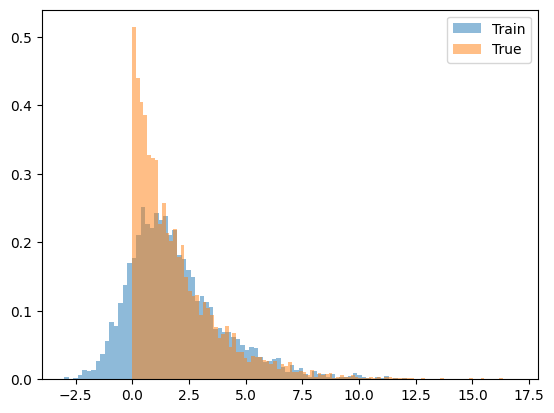

In [20]:
u, x = make_exp(size = 5000, dim = 1)

# for 1d data visualization
plt.hist(x, bins=100, label='Train', alpha=0.5, density=True)
plt.hist(u, bins=100, label='True', alpha=0.5, density=True)
plt.legend()
plt.show()

np.save('./exp1d_u', u)
np.save('./exp1d_x', x)

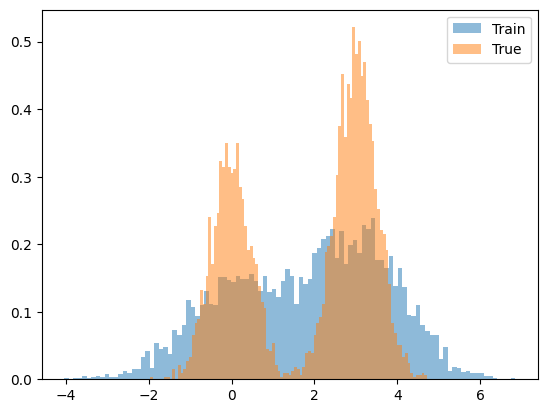

In [21]:
u, x = make_mix(size = 5000, dim = 1)

# for 1d data visualization
plt.hist(x, bins=100, label='Train', alpha=0.5, density=True)
plt.hist(u, bins=100, label='True', alpha=0.5, density=True)
plt.legend()
plt.show()

np.save('./mix1d_u', u)
np.save('./mix1d_x', x)

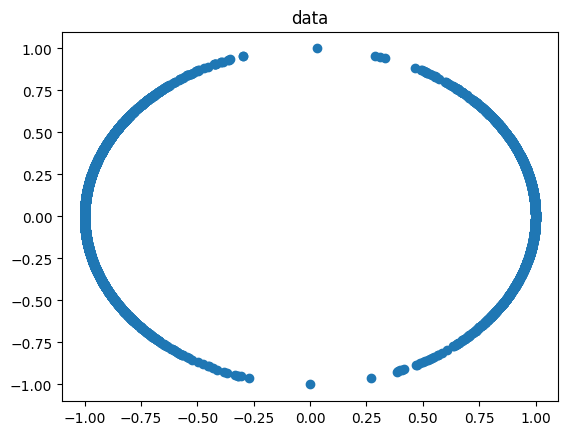

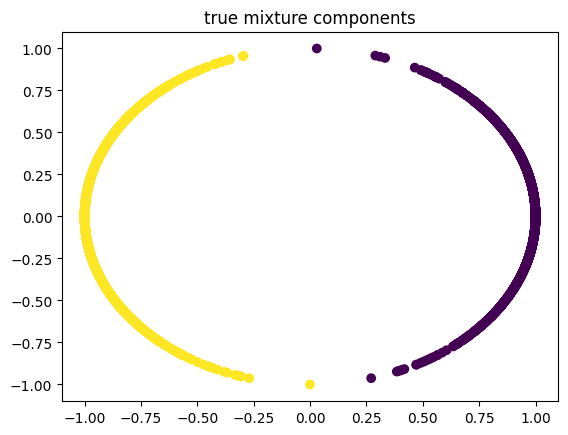

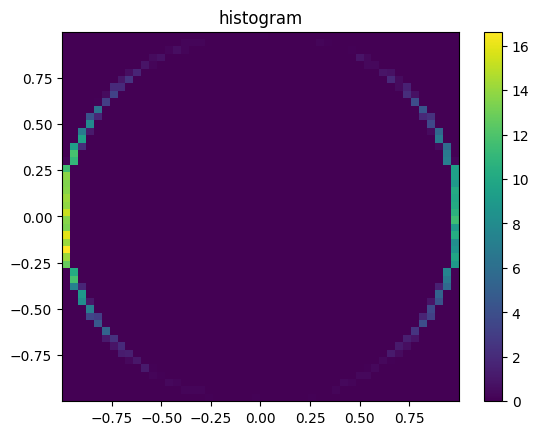

In [48]:
u, x = make_circle(size = 5000) 

plt.scatter(x[:, 0], x[:, 1])
plt.title('data')
plt.show()

plt.scatter(x[:, 0], x[:, 1], c = u)
plt.title('true mixture components')
plt.show()

plt.hist2d(x[:, 0], x[:, 1], bins=50, density=True)
plt.title('histogram')
plt.colorbar()
plt.show()

np.save('./circle_u', u)
np.save('./circle_x', x)

From here, I recommend creating a new virtual environment for scvi package.
This is because scvi sometimes conflicts with some installed packages, e.g., pytorch.
So, the data will be preprocessed in this notebook, and we will never activate this environment except now.

In [2]:
import scvi
import scanpy as sc
import numpy as np

adata = scvi.data.cortex()

INFO     File /home/users/urikokp2/My/IS/data/data/expression.bin already downloaded                               
INFO     Loading Cortex data from /home/users/urikokp2/My/IS/data/data/expression.bin                              
INFO     Finished loading Cortex data                                                                              


/home/users/urikokp2/.conda/envs/scvi1/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
def preprocessing(adata, batch_key = None):
    sc.pp.filter_genes(adata, min_counts=3)
    adata.layers["counts"] = adata.X.copy() # preserve counts
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata # freeze the state in `.raw`

    sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key=batch_key
    )

In [4]:
adata = scvi.data.cortex()
preprocessing(adata)
df = adata.layers['counts']
labels = adata.obs['cell_type']

INFO     File /home/users/urikokp2/My/IS/data/data/expression.bin already downloaded                               
INFO     Loading Cortex data from /home/users/urikokp2/My/IS/data/data/expression.bin                              
INFO     Finished loading Cortex data                                                                              


/home/users/urikokp2/.conda/envs/scvi1/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
np.save('cortex_x', df)
np.save('cortex_u', labels)